# Glycolysis

To construct a model of glycolysis, first we import <b>masspy</b> and other essential packages. Constants used throughout the notebook are also defined.

In [1]:
from os import path

import matplotlib.pyplot as plt

from cobra import DictList

from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.core.visualization import plot_simulation
from mass.io import json, sbml
from mass.util import qcqa_model

mass_config = MassConfiguration()

## Model Construction 

The first step of creating a model of glycolysis is to define the <font color=#4682B4>MassModel</font>. 

In [2]:
glycolysis = MassModel("Glycolysis")

### Metabolites

The next step is to define all of the metabolites using the <font color=#4682B4>MassMetabolite</font> object. Some considerations for this step include the following:

1. It is important to use a clear and consistent format for identifiers and names when defining the <font color=#4682B4>MassMetabolite</font> objects for various reasons, some of which include improvements to model clarity and utility, assurance of unique identifiers (required to add metabolites to the model), and consistency when collaborating and communicating with others. 


2. In order to ensure our model is physiologically accurate, it is important to provide the <font color=#B22222>formula</font> argument with a string representing the chemical formula for each metabolite, and the <font color=#B22222>charge</font> argument with an integer representing the metabolite's ionic charge (Note that neutrally charged metabolites are provided with 0). These attributes can always be set later if necessary using the <font color=#1E90FF>formula</font> and <font color=#1E90FF>charge</font> attribute set methods.


3. To indicate that the cytosol is the cellular compartment in which the reactions occur, the string "c" is provided to the <font color=#B22222>compartment</font> argument.

This model will be created using identifiers and names found in the [BiGG Database](http://bigg.ucsd.edu/).

In this model, there are 20 metabolites inside the cytosol compartment. 

In [3]:
glc__D_c = MassMetabolite(
    "glc__D_c",
    name="D-Glucose",
    formula="C6H12O6",
    charge=0,
    compartment="c",
    fixed=False)

g6p_c = MassMetabolite(
    "g6p_c",
    name="D-Glucose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c",
    fixed=False)

f6p_c = MassMetabolite(
    "f6p_c",
    name="D-Fructose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c",
    fixed=False)

fdp_c = MassMetabolite(
    "fdp_c",
    name="D-Fructose 1,6-bisphosphate",
    formula="C6H10O12P2",
    charge=-4,
    compartment="c",
    fixed=False)

dhap_c = MassMetabolite(
    "dhap_c",
    name="Dihydroxyacetone phosphate",
    formula="C3H5O6P",
    charge=-2,
    compartment="c",
    fixed=False)

g3p_c = MassMetabolite(
    "g3p_c",
    name="Glyceraldehyde 3-phosphate",
    formula="C3H5O6P",
    charge=-2,
    compartment="c",
    fixed=False)

_13dpg_c = MassMetabolite(
    "_13dpg_c",
    name="3-Phospho-D-glyceroyl phosphate",
    formula="C3H4O10P2",
    charge=-4,
    compartment="c",
    fixed=False)

_3pg_c = MassMetabolite(
    "_3pg_c",
    name="3-Phospho-D-glycerate",
    formula="C3H4O7P",
    charge=-3,
    compartment="c",
    fixed=False)

_2pg_c = MassMetabolite(
    "_2pg_c",
    name="D-Glycerate 2-phosphate",
    formula="C3H4O7P",
    charge=-3,
    compartment="c",
    fixed=False)

pep_c = MassMetabolite(
    "pep_c",
    name="Phosphoenolpyruvate",
    formula="C3H2O6P",
    charge=-3,
    compartment="c",
    fixed=False)

pyr_c = MassMetabolite(
    "pyr_c",
    name="Pyruvate",
    formula="C3H3O3",
    charge=-1,
    compartment="c",
    fixed=False)

lac__L_c = MassMetabolite(
    "lac__L_c",
    name="L-Lactate",
    formula="C3H5O3",
    charge=-1,
    compartment="c",
    fixed=False)

nad_c = MassMetabolite(
    "nad_c",
    name="Nicotinamide adenine dinucleotide",
    formula="C21H26N7O14P2",
    charge=-1,
    compartment="c",
    fixed=False)

nadh_c = MassMetabolite(
    "nadh_c",
    name="Nicotinamide adenine dinucleotide - reduced",
    formula="C21H27N7O14P2",
    charge=-2,
    compartment="c",
    fixed=False)

atp_c = MassMetabolite(
    "atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c",
    fixed=False)

adp_c = MassMetabolite(
    "adp_c",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="c",
    fixed=False)

amp_c = MassMetabolite(
    "amp_c",
    name="AMP",
    formula="C10H12N5O7P",
    charge=-2,
    compartment="c",
    fixed=False)

h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c",
    fixed=False)

pi_c = MassMetabolite(
    "pi_c",
    name="Phosphate",
    formula="HPO4",
    charge=-2,
    compartment="c",
    fixed=False)

h2o_c = MassMetabolite(
    "h2o_c",
    name="H2O",
    formula="H2O",
    charge=0,
    compartment="c",
    fixed=False)

### Reactions

Once all of the <font color=#4682B4>MassMetabolites</font> for each metabolite, the next step is to define all of the reactions that occur and their stoichiometry.

1. As with the metabolites, it is also important to use a clear and consistent format for identifiers and names when defining when defining the <font color=#4682B4>MassReactions</font>.


2. To make this model useful for integration with other models, it is important to provide a string to the <font color=#B22222>subsystem</font> argument. By providing the subsystem, the reactions can be easily obtained even when integrated with a significantly larger model through the <font color=#1E90FF>subsystem</font> attribute


3. After the creation of each <font color=#4682B4>MassReaction</font> object, the metabolites are added to the reaction using a dictionary where keys are the <font color=#4682B4>MassMetabolites</font> and values are the stoichiometric coefficients (reactants have negative coefficients, products have positive ones). 

This model will be created using identifiers and names found in the [BiGG Database](http://bigg.ucsd.edu/).

In this model, there are 14 reactions occuring inside the cytosol compartment.

In [4]:
HEX1 = MassReaction(
    "HEX1",
    name="Hexokinase (D-glucose:ATP)",
    subsystem=glycolysis.id,
    reversible=True)
HEX1.add_metabolites({
    glc__D_c: -1,
    atp_c: -1,
    adp_c: 1,
    g6p_c: 1,
    h_c: 1})

PGI = MassReaction(
    "PGI",
    name="Glucose-6-phosphate isomerase",
    subsystem=glycolysis.id,
    reversible=True)
PGI.add_metabolites({
    g6p_c: -1,
    f6p_c: 1})

PFK = MassReaction(
    "PFK",
    name="Phosphofructokinase",
    subsystem=glycolysis.id,
    reversible=True)
PFK.add_metabolites({
    f6p_c: -1,
    atp_c: -1,
    fdp_c: 1,
    adp_c: 1,
    h_c: 1})

FBA = MassReaction(
    "FBA",
    name="Fructose-bisphosphate aldolase",
    subsystem=glycolysis.id,
    reversible=True)
FBA.add_metabolites({
    fdp_c: -1,
    dhap_c: 1,
    g3p_c: 1})

TPI = MassReaction(
    "TPI",
    name="Triose-phosphate isomerase",
    subsystem=glycolysis.id,
    reversible=True)
TPI.add_metabolites({
    dhap_c: -1,
    g3p_c: 1})

GAPD = MassReaction(
    "GAPD",
    name="Glyceraldehyde-3-phosphate dehydrogenase",
    subsystem=glycolysis.id,
    reversible=True)
GAPD.add_metabolites({
    g3p_c: -1,
    nad_c: -1,
    pi_c: -1,
    _13dpg_c: 1,
    h_c: 1,
    nadh_c: 1})

PGK = MassReaction(
    "PGK",
    name="Phosphoglycerate kinase",
    subsystem=glycolysis.id,
    reversible=True)
PGK.add_metabolites({
    _13dpg_c: -1,
    adp_c: -1,
    _3pg_c: 1,
    atp_c: 1})

PGM = MassReaction(
    "PGM",
    name="Phosphoglycerate mutase",
    subsystem=glycolysis.id,
    reversible=True)
PGM.add_metabolites({
    _3pg_c: -1,
    _2pg_c: 1})

ENO = MassReaction(
    "ENO",
    name="Enolase",
    subsystem=glycolysis.id,
    reversible=True)
ENO.add_metabolites({
    _2pg_c: -1,
    h2o_c: 1,
    pep_c: 1})

PYK = MassReaction(
    "PYK",
    name="Pyruvate kinase",
    subsystem=glycolysis.id,
    reversible=True)
PYK.add_metabolites({
    pep_c: -1,
    h_c: -1,
    adp_c: -1,
    atp_c: 1,
    pyr_c: 1})

LDH_L = MassReaction(
    "LDH_L",
    name="L-lactate dehydrogenase",
    subsystem=glycolysis.id,
    reversible=True)
LDH_L.add_metabolites({
    h_c: -1,
    nadh_c: -1,
    pyr_c: -1,
    lac__L_c: 1,
    nad_c: 1})

ADK1 = MassReaction(
    "ADK1",
    name="Adenylate kinase",
    subsystem="Misc.",
    reversible=True)
ADK1.add_metabolites({
    adp_c: -2,
    amp_c: 1,
    atp_c: 1})

ATPM = MassReaction(
    "ATPM",
    name="ATP maintenance requirement",
    subsystem="Pseudoreaction",
    reversible=False)
ATPM.add_metabolites({
    atp_c: -1,
    h2o_c: -1,
    adp_c: 1,
    h_c: 1,
    pi_c: 1})

DM_nadh = MassReaction(
    "DM_nadh",
    name="Demand NADH",
    subsystem="Pseudoreaction",
    reversible=False)
DM_nadh.add_metabolites({
    nadh_c: -1,
    nad_c: 1,
    h_c: 1})

After generating the reactions, all reactions are added to the model through the <font color=#4682B4>MassModel</font><font color=#00008B>.add_reactions</font> class method. Adding the <font color=#4682B4>MassReactions</font> will also add their associated <font color=#4682B4>MassMetabolites</font> if they have not already been added to the model. 

In [5]:
glycolysis.add_reactions([
    HEX1, PGI, PFK, FBA, TPI, GAPD, PGK,
    PGM, ENO, PYK, LDH_L, ADK1, ATPM, DM_nadh])

for reaction in glycolysis.reactions:
    print(reaction)

HEX1: atp_c + glc__D_c <=> adp_c + g6p_c + h_c
PGI: g6p_c <=> f6p_c
PFK: atp_c + f6p_c <=> adp_c + fdp_c + h_c
FBA: fdp_c <=> dhap_c + g3p_c
TPI: dhap_c <=> g3p_c
GAPD: g3p_c + nad_c + pi_c <=> _13dpg_c + h_c + nadh_c
PGK: _13dpg_c + adp_c <=> _3pg_c + atp_c
PGM: _3pg_c <=> _2pg_c
ENO: _2pg_c <=> h2o_c + pep_c
PYK: adp_c + h_c + pep_c <=> atp_c + pyr_c
LDH_L: h_c + nadh_c + pyr_c <=> lac__L_c + nad_c
ADK1: 2 adp_c <=> amp_c + atp_c
ATPM: atp_c + h2o_c --> adp_c + h_c + pi_c
DM_nadh: nadh_c --> h_c + nad_c


### Boundary reactions

After generating the reactions, the next step is to add the boundary reactions and boundary conditions (the concentrations of the boundary 'metabolites' of the system). This can easily be done using the <font color=#4682B4>MassModel</font><font color=#00008B>.add_boundary</font> method. With the generation of the boundary reactions, the system becomes an open system, allowing for the flow of mass through the biochemical pathways of the model.

Once added, the model will be able to return the boundary conditions as a dictionary through the <font color=#4682B4>MassModel</font><font color=#1E90FF>.boundary_conditions</font> attribute 

In this model, there are 8 boundary reactions that must be defined.

All boundary reactions are originally created with the metabolite as the reactant. However, there are times where it would be preferable to represent the metabolite as the product. For these situtations, the <font color=#4682B4>MassReaction</font><font color=#1E90FF>.reverse_stoichiometry</font> method can be used with its <font color=#B22222>inplace</font> argument to create a new <font color=#4682B4>MassReaction</font> or simply reverse the stoichiometry for the current <font color=#4682B4>MassReaction.</font> 

In [6]:
SK_glc__D_c = glycolysis.add_boundary(
    metabolite=glc__D_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_glc__D_c.reverse_stoichiometry(inplace=True)

SK_lac__L_c = glycolysis.add_boundary(
    metabolite=lac__L_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)

SK_pyr_c = glycolysis.add_boundary(
    metabolite=pyr_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=0.06)

SK_h_c = glycolysis.add_boundary(
    metabolite=h_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=6.30957e-05)

SK_h2o_c = glycolysis.add_boundary(
    metabolite=h2o_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)

SK_amp_c = glycolysis.add_boundary(
    metabolite=amp_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_amp_c.reverse_stoichiometry(inplace=True)

DM_amp_c = glycolysis.add_boundary(
    metabolite=amp_c, boundary_type="demand", subsystem="Pseudoreaction",
    boundary_condition=1)

SK_pi_c = glycolysis.add_boundary(
    metabolite=pi_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=2.5)

print("Boundary Reactions and Values\n-----------------------------")
for reaction in glycolysis.boundary:
    boundary_met = reaction.boundary_metabolite
    bc_value = glycolysis.boundary_conditions.get(boundary_met)
    print("{0}\n{1}: {2}\n".format(
        reaction, boundary_met, bc_value))

Boundary Reactions and Values
-----------------------------
SK_glc__D_c:  <=> glc__D_c
glc__D_b: 1.0

SK_lac__L_c: lac__L_c <=> 
lac__L_b: 1.0

SK_pyr_c: pyr_c <=> 
pyr_b: 0.06

SK_h_c: h_c <=> 
h_b: 6.30957e-05

SK_h2o_c: h2o_c <=> 
h2o_b: 1.0

SK_amp_c:  <=> amp_c
amp_b: 1.0

DM_amp_c: amp_c --> 
amp_b: 1.0

SK_pi_c: pi_c <=> 
pi_b: 2.5



### Optional: Ordering of internal species and reactions

Sometimes, it is also desirable to reorder the metabolite and reaction objects inside the model to follow the physiology. To reorder the internal species, one can use <font color=#008000>cobra</font><font color=#556B2F>.DictLists</font> and the <font color=#556B2F>DictList</font><font color=#006400>.get_by_any</font> with the list of metabolite identifiers in the desirable order. To ensure all metabolites are still present and not forgotten in the model, a small QA check is also performed. 

In [7]:
new_metabolite_order = [
    "glc__D_c", "g6p_c", "f6p_c", "fdp_c", "dhap_c",
    "g3p_c", "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c",
    "pyr_c", "lac__L_c", "nad_c", "nadh_c", "amp_c",
    "adp_c", "atp_c", "pi_c", "h_c", "h2o_c"]

if len(glycolysis.metabolites) == len(new_metabolite_order):
    glycolysis.metabolites = DictList(
        glycolysis.metabolites.get_by_any(new_metabolite_order))
    
new_reaction_order = [
    "HEX1", "PGI", "PFK", "FBA", "TPI",
    "GAPD", "PGK", "PGM", "ENO", "PYK",
    "LDH_L", "DM_amp_c", "ADK1", "SK_pyr_c",
    "SK_lac__L_c", "ATPM", "DM_nadh", "SK_glc__D_c",
    "SK_amp_c", "SK_h_c", "SK_h2o_c", "SK_pi_c"]

if len(glycolysis.reactions) == len(new_reaction_order):
    glycolysis.reactions = DictList(
        glycolysis.reactions.get_by_any(new_reaction_order))
    
glycolysis.update_S(matrix_type="DataFrame", dtype=int)

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,...,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_amp_c,SK_h_c,SK_h2o_c,SK_pi_c
glc__D_c,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
g6p_c,1,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f6p_c,0,1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fdp_c,0,0,1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dhap_c,0,0,0,1,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g3p_c,0,0,0,1,1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_13dpg_c,0,0,0,0,0,1,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_3pg_c,0,0,0,0,0,0,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
_2pg_c,0,0,0,0,0,0,0,1,-1,0,...,0,0,0,0,0,0,0,0,0,0
pep_c,0,0,0,0,0,0,0,0,1,-1,...,0,0,0,0,0,0,0,0,0,0


## Model Parameterization
### Steady State fluxes
Steady state fluxes can be computed as a summation of the MinSpan pathway vectors. 

Pathways are obtained using the minspan package (https://github.com/SBRG/minspan). 

Using these pathways and literature sources, independent fluxes can be defined in order to calculate the steady state flux vector. For this model, flux and concentration data are obtained from the historical human red blood cell (RBC) metabolic model (Heinrich 1977, Jamshidi 2002, Joshi 1988, Joshi 1990, Joshi 1989-II). 

From the literature, it is known that:

1. A typical uptake rate of the RBC of glucose is about 1.12 mM/hr. 
2. Based on experimental data, the steady state load on NADH is set at 20% of the glucose uptake rate, or $0.2 * 1.12 = 0.244. 
3. The synthesis rate of AMP is measured to be 0.014 mM/hr. 

With these pathays and numerical values, the steady state flux vector can be computed as the weighted sum of the corresponding basis vectors. The steady state flux vector is computed as an inner product:

In [8]:
minspan_paths = [
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, -1, 0, 1, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]
glycolysis.compute_steady_state_fluxes(
    pathways=minspan_paths,
    independent_fluxes={
        SK_glc__D_c: 1.12,
        DM_nadh: .2 * 1.12,
        DM_amp_c: 0.014},
    update_reactions=True)

print("Steady State Fluxes\n-------------------")
for reaction, steady_state_flux in glycolysis.steady_state_fluxes.items():
    print("{0}: {1:.6f}".format(reaction.flux_symbol, steady_state_flux))

Steady State Fluxes
-------------------
v_HEX1: 1.120000
v_PGI: 1.120000
v_PFK: 1.120000
v_FBA: 1.120000
v_TPI: 1.120000
v_GAPD: 2.240000
v_PGK: 2.240000
v_PGM: 2.240000
v_ENO: 2.240000
v_PYK: 2.240000
v_LDH_L: 2.016000
v_DM_amp_c: 0.014000
v_ADK1: 0.000000
v_SK_pyr_c: 0.224000
v_SK_lac__L_c: 2.016000
v_ATPM: 2.240000
v_DM_nadh: 0.224000
v_SK_glc__D_c: 1.120000
v_SK_amp_c: 0.014000
v_SK_h_c: 2.688000
v_SK_h2o_c: 0.000000
v_SK_pi_c: 0.000000


### Initial Conditions

Once the network has been built, the concentrations can be added to the metabolites. These concentrations are also treated as the initial conditions required to integrate and simulate the model's ordinary differential equations (ODEs). The metabolite concentrations are added to each individual metabolite using the <font color=#4682B4>MassMetabolite</font><font color=#1E90FF>.initial_condition</font> (shorthand: <font color=#4682B4>MassMetabolite</font><font color=#1E90FF>.ic</font>) attribute setter methods. Once added, the model will be able to return the initial conditions as a dictionary through the <font color=#4682B4>MassModel</font><font color=#1E90FF>.initial_conditions</font> attribute.

In [9]:
glc__D_c.ic = 1.0
g6p_c.ic = 0.0486
f6p_c.ic = 0.0198
fdp_c.ic = 0.0146
g3p_c.ic = 0.00728
dhap_c.ic = 0.16
_13dpg_c.ic = 0.000243
_3pg_c.ic = 0.0773
_2pg_c.ic = 0.0113
pep_c.ic = 0.017
pyr_c.ic = 0.060301
lac__L_c.ic = 1.36
atp_c.ic = 1.6
adp_c.ic = 0.29
amp_c.ic = 0.0867281
h_c.ic = 0.0000899757
nad_c.ic = 0.0589
nadh_c.ic = 0.0301
pi_c.ic = 2.5
h2o_c.ic = 1.0

print("Initial Conditions\n------------------")
for metabolite, ic_value in glycolysis.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
glc__D_c: 1.0
g6p_c: 0.0486
f6p_c: 0.0198
fdp_c: 0.0146
dhap_c: 0.16
g3p_c: 0.00728
_13dpg_c: 0.000243
_3pg_c: 0.0773
_2pg_c: 0.0113
pep_c: 0.017
pyr_c: 0.060301
lac__L_c: 1.36
nad_c: 0.0589
nadh_c: 0.0301
amp_c: 0.0867281
adp_c: 0.29
atp_c: 1.6
pi_c: 2.5
h_c: 8.99757e-05
h2o_c: 1.0


### Equilibirum Constants

After adding initial conditions and steady state fluxes, the equilibrium constants are defined using the <font color=#4682B4>MassReaction</font><font color=#1E90FF>.equilibrium_constant</font> (shorthand: <font color=#4682B4>MassReaction</font><font color=#1E90FF>.Keq</font>) setter method. 

In [10]:
HEX1.Keq = 850
PGI.Keq = 0.41
PFK.Keq = 310
FBA.Keq = 0.082
TPI.Keq = 0.0571429
GAPD.Keq = 0.0179
PGK.Keq = 1800
PGM.Keq = 0.147059
ENO.Keq = 1.69492
PYK.Keq = 363000
LDH_L.Keq = 26300
ADK1.Keq = 1.65

SK_glc__D_c.Keq = mass_config.irreversible_Keq
SK_lac__L_c.Keq = 1
SK_pyr_c.Keq = 1
SK_h_c.Keq = 1
SK_h2o_c.Keq = 1
SK_amp_c.Keq = mass_config.irreversible_Keq
SK_pi_c.Keq = 1

print("Equilibrium Constants\n---------------------")
for reaction in glycolysis.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

Equilibrium Constants
---------------------
Keq_HEX1: 850
Keq_PGI: 0.41
Keq_PFK: 310
Keq_FBA: 0.082
Keq_TPI: 0.0571429
Keq_GAPD: 0.0179
Keq_PGK: 1800
Keq_PGM: 0.147059
Keq_ENO: 1.69492
Keq_PYK: 363000
Keq_LDH_L: 26300
Keq_DM_amp_c: inf
Keq_ADK1: 1.65
Keq_SK_pyr_c: 1
Keq_SK_lac__L_c: 1
Keq_ATPM: inf
Keq_DM_nadh: inf
Keq_SK_glc__D_c: inf
Keq_SK_amp_c: inf
Keq_SK_h_c: 1
Keq_SK_h2o_c: 1
Keq_SK_pi_c: 1


### Calculation of PERCs
By defining the equilibrium constant and steady state parameters, the values of the pseudo rate constants (PERCs) can be calculated and added to the model using the <font color=#4682B4>MassModel</font><font color=#00008B>.calculate_PERCs</font> method.

From literature, it is known that the rate of the phosphate uptake is 0.26/hr. Therefore, the PERC for the phosphate exchange is updated manually using the <font color=#4682B4>MassReaction</font><font color=#1E90FF>.forward_rate_constant</font> (shorthand: <font color=#4682B4>MassReaction</font><font color=#1E90FF>.kf</font>) setter method:

In [11]:
glycolysis.calculate_PERCs(update_reactions=True)
SK_pi_c.forward_rate_constant = 0.26

print("Forward Rate Constants\n----------------------")
for reaction in glycolysis.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

Forward Rate Constants
----------------------
kf_HEX1: 0.700007
kf_PGI: 3644.444444
kf_PFK: 35.368784
kf_FBA: 2834.567901
kf_TPI: 34.355728
kf_GAPD: 3376.749242
kf_PGK: 1273531.269741
kf_PGM: 4868.589299
kf_ENO: 1763.740525
kf_PYK: 454.385552
kf_LDH_L: 1112.573989
kf_DM_amp_c: 0.161424
kf_ADK1: 100000.000000
kf_SK_pyr_c: 744.186047
kf_SK_lac__L_c: 5.600000
kf_ATPM: 1.400000
kf_DM_nadh: 7.441860
kf_SK_glc__D_c: 1.120000
kf_SK_amp_c: 0.014000
kf_SK_h_c: 100000.000000
kf_SK_h2o_c: 100000.000000
kf_SK_pi_c: 0.260000


## QC/QA Model

Before simulating the model, it is important to ensure that the model is elementally balanced, and that the model can simulate. Therefore, the <font color=#00008B>qcqa_model</font> function from the <font color=#0000FF>mass.util.qcqa</font></td> submodule is used to provide a report on the model quality and indicate whether simulation is possible and if not, what parameters and/or initial conditions are missing. 

Generally, pseudoreactions (e.g. boundary exchanges, sinks, demands) are not elementally balanced. The <font color=#00008B>qcqa_model</font> function does not include elemental balancing of boundary reactions. 

However, some models contain pseudoreactions reprsenting a simplified mechanism, and show up in the returned report. The elemental imbalance of these pseudoreactions is therefore expected in certain reaction and should not be a cause for concern. 

In this model of glycolysis, the NADH demand reaction is a simplified pseudoreaction that generates electrons for certain redox processes and is not expected to be balanced.

In [12]:
qcqa_model(glycolysis, parameters=True, concentrations=True, 
           fluxes=True, superfluous=True, elemental=True)

╒══════════════════════════════════════════════╕
│ MODEL ID: Glycolysis                         │
│ SIMULATABLE: True;                           │
│ NUMERICALLY CONSISTENT: True                 │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ============================================ │
│ Elemental                                    │
│ ---------------------------------            │
│ DM_nadh: {charge: 2.0} unbalanced            │
│ ============================================ │
╘══════════════════════════════════════════════╛


From the results of the QC/QA test, it can be seen that the model can be simulated and is numerically consistent.

## Steady State and Model Validation 

To find the steady state of the model and perform simulations, the model must first be loaded into a <font color=#4682B4>Simulation</font>. In order to load a model into a <font color=#4682B4>Simulation</font>, the model must be simulatable, meaning there are no missing numerical values that would prevent the integration of the ODEs that comprise the model. The <font color=#B22222>verbose</font> argument can be used while loading a model to produce a message indicating the successful loading of a model, or why a model could not load.

Once loaded into a <font color=#4682B4>Simulation</font>, the <font color=#00008B>find_steady_state</font> method can be used with the <font color=#B22222>update_values</font> argument in order to update the initial conditions and fluxes of the model to a steady state. The model can then be simulated using the <font color=#00008B>simulate</font> method by passing the model to simulate, and a tuple containing the start time and the end time. The number of time points can also be included, but is optional.

After a successful simulation, two <font color=#008000>cobra</font><font color=#556B2F>.DictLists</font> are returned. The first <font color=#556B2F>DictList</font> holds a <font color=#4682B4>MassSolution</font> that contains the concentration results of the simulation, and the second <font color=#556B2F>DictList</font> hold a <font color=#4682B4>MassSolution</font> that contains the flux results of the simulation. Note that there will always be two <font color=#4682B4>MassSolutions</font> generated per model simulated.

To visually validate the steady state of the model, concentration and flux solutions can be plotted using the <font color=#00008B>plot_simulation</font> function from <font color=#0000FF>mass.core.visualization</font></td>. Alternatively, the <font color=#4682B4>MassSolution</font><font color=#1E90FF>.preview_time_profile</font> property can be used to quickly generate a time profile for the results.

'roadrunner Notice: Successfully loaded Model 'Glycolysis' into RoadRunner.'


'roadrunner Warning: Conserved Moiety Analysis is not enabled, steady state may fail with singular Jacobian'


'roadrunner Warning: Conserved Moiety Analysis may be enabled via the conservedMoeityAnalysis property or via the configuration file or the Config class setValue, see roadrunner documentation'


'roadrunner Warning: to remove this warning, set ROADRUNNER_DISABLE_WARNINGS to 1 or 3 in the config file'


'roadrunner Error: Error :Jacobian matrix singular in NLEQ. Failed to converge to steady state. Check if Jacobian matrix is non-invertible or steady state solution does not exist.'


'roadrunner Warning: Steady state solver failed. However, RoadRunner approximated the solution successfully.'


'roadrunner Warning: Conserved Moiety Analysis is not enabled, steady state may fail with singular Jacobian'


'roadrunner Warning: Conserved Moiety Analysis may be enabled via the conservedMoeityAnalysis property or via the configuration file or the Config class setValue, see roadrunner documentation'


'roadrunner Warning: to remove this warning, set ROADRUNNER_DISABLE_WARNINGS to 1 or 3 in the config file'


'roadrunner Error: Error :Jacobian matrix singular in NLEQ. Failed to converge to steady state. Check if Jacobian matrix is non-invertible or steady state solution does not exist.'


'roadrunner Warning: Steady state solver failed. However, RoadRunner approximated the solution successfully.'


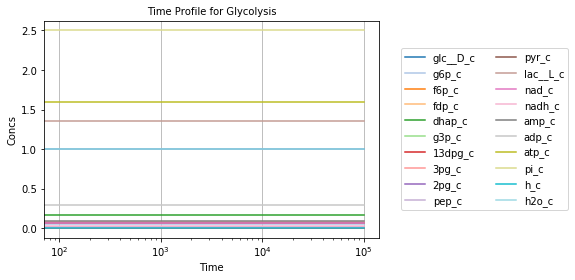

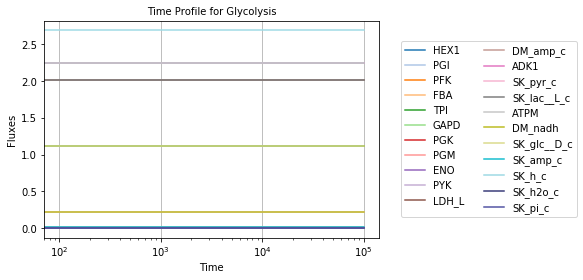

In [13]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(glycolysis, verbose=True)
sim.find_steady_state(glycolysis, strategy="nleq2", update_values=True)
# Simulate from 0 to 100000 with 1001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e5, 1001))
# Quickly render and display time profiles 
for sol in [conc_sol[0], flux_sol[0]]:
    sol.preview_time_profile
    plt.show()

### Optional: Storing information and references
#### Compartment
Because the character "c" represents the cytosol compartment, it is recommended to define and set the compartment in the <font color=#4682B4>MassModel</font><font color=#1E90FF>.compartments</font> attribute.

In [14]:
glycolysis.compartments = {"c": "Cytosol"}
print(glycolysis.compartments)

{'c': 'Cytosol'}


#### Units
All of the units for the numerical values used in this model are "Millimoles" for amount and "Liters" for volume (giving a concentration unit of 'Millimolar'), and "Hours" for time. In order to ensure that future users understand the numerical values for model, it is important to define the <font color=#4682B4>MassModel</font><font color=#1E90FF>.units</font> attribute.

The <font color=#4682B4>MassModel</font><font color=#1E90FF>.units</font> is a <font color=#008000>cobra</font><font color=#556B2F>.DictList</font> that contains only <font color=#4682B4>UnitDefinition</font> objects from the <font color=#0000FF>mass.core.unit</font> submodule. 

Each <font color=#4682B4>UnitDefinition</font> is created from <font color=#4682B4>Unit</font> objects representing the base units that comprise the <font color=#4682B4>UnitDefinition</font>. These <font color=#4682B4>Units</font> are stored in the <font color=#1E90FF>list_of_units</font> attribute. Pre-built units can be viewed using the <font color=#00008B>print_defined_unit_values</font> function from the <font color=#0000FF>mass.core.unit</font></td> submodule. Alternatively, custom units can also be created using the <font color=#4682B4>UnitDefinition</font><font color=#00008B>.create_unit</font> function.

For more information about units, please see the module docstring for <font color=#0000FF>mass.core.unit</font> submodule.

__Note:__ It is important to note that this attribute will NOT track units, but instead acts as a reference for the user and others so that they can perform necessary unit conversions.

In [15]:
# Using pre-build units to define UnitDefinitions
concentration = UnitDefinition("mM", name="Millimolar", list_of_units=["millimole", "per_litre"])
time = UnitDefinition("hr", name="hour", list_of_units=["hour"])

# Add units to model
glycolysis.add_units([concentration, time])
print(glycolysis.units)

[<UnitDefinition Millimolar "mM" at 0x122c0b588>, <UnitDefinition hour "hr" at 0x122c0bda0>]


## Export

After validation, the model is ready to be saved. The model can either be exported as a ".json" file or as an ".sbml" (".xml") file using their repsective submodules in <font color=#0000FF>mass.io</font></td>.

To export the model, only the path to the directory and the name of the model need to be specified. Both are shown below. 

In [16]:
filepath = path.realpath(path.join("models", "SB2_" + glycolysis.id))

### Export using JSON

In [17]:
json.save_json_model(mass_model=glycolysis, filename=filepath + ".json")

### Export using SBML

In [18]:
sbml.write_sbml_model(mass_model=glycolysis, filename=filepath + ".xml")